# Brownian Motion Stock Predictions

In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import scipy
import fitter
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

In [146]:
aapl = yf.Ticker("AAPL")
historical_data = aapl.history(period="10y")
historical_data.index = pd.to_datetime(historical_data.index).strftime('%Y-%m-%d')
historical_data.reset_index(inplace=True)
historical_data['Date'] = pd.to_datetime(historical_data['Date'])

historical_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2013-12-23,17.784320,17.869485,17.620255,17.849760,501306400,0.0,0.0
1,2013-12-24,17.843485,17.905793,17.722627,17.773977,167554800,0.0,0.0
2,2013-12-26,17.787442,17.831278,17.639657,17.655939,204008000,0.0,0.0
3,2013-12-27,17.653438,17.671910,17.518177,17.536650,225884400,0.0,0.0
4,2013-12-30,17.454294,17.536639,17.293357,17.362240,253629600,0.0,0.0
...,...,...,...,...,...,...,...,...
2513,2023-12-18,196.089996,196.630005,194.389999,195.889999,55751900,0.0,0.0
2514,2023-12-19,196.160004,196.949997,195.889999,196.940002,40714100,0.0,0.0
2515,2023-12-20,196.899994,197.679993,194.830002,194.830002,52242800,0.0,0.0
2516,2023-12-21,196.100006,197.080002,193.500000,194.679993,46482500,0.0,0.0


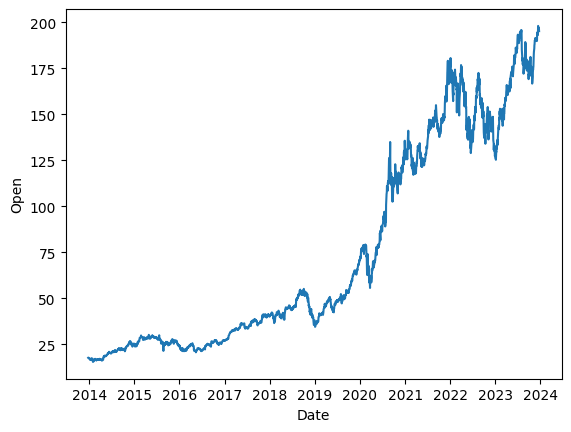

In [147]:
sns.lineplot(x='Date', y='Open', data=historical_data)
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%Y'))
plt.show()

In [148]:
print(historical_data.at[2266, 'Date'])
print(historical_data.at[2517, 'Date']) #-> the actual length is 2517, so the sample is from 0-> 2013, the test is from 2013 -> 2265 (252 trading days) and the prediction will be from 2265 -> 2517(today) or another 252 trading days

prices = historical_data['Close']
test_set = prices[2266:2518]
sample = prices[0:2266]


# test_set = prices[2700:2700 + 252] -> if we want to test for 252 days after december 22, 2023
# sample = prices[0:2700]
returns = prices.pct_change().dropna()

2022-12-22 00:00:00
2023-12-22 00:00:00


# Brownian Motion

In [149]:
returns = prices.pct_change().dropna()
volatility = returns.std() * (252**0.5)
mu = returns.mean() * 252
sigma = volatility
sNaught = prices.iloc[-1]
T = 1
dt = 1/252
inter = int(T/dt)
np.random.seed(20) 
sims = 1000
paths = np.zeros((inter + 1, sims))
paths[0] = sNaught
for t in range(1, inter + 1):
    z_score = np.random.standard_normal(sims)
    paths[t] = paths[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma  * z_score)

In [150]:
def calc(paths, sn, mu, sigma, T):
    pts = paths[-1]
    scale = sn * np.exp(mu * T)
    probabilities = scipy.stats.lognorm.pdf(pts, s=sigma * np.sqrt(T), scale=scale)
    return probabilities

probabilities = calc(paths, sNaught, mu, sigma, T)
normalized = probabilities / probabilities.max()
indices = np.argsort(normalized)
paths = paths[:, indices]
new_probabilities = normalized[indices]
d = (paths[-1] - sNaught).mean() / sNaught

In [151]:
returns = sample.pct_change().dropna()
volatility = returns.std() * (252**0.5)
mu = returns.mean() * 252
sigma = volatility
sNaught = sample.iloc[-1]
T = 1
dt = 1/252
inter = int(T/dt)

np.random.seed(20) 
sims = 100
paths = np.zeros((inter + 1, sims))
paths[0] = sNaught
for t in range(1, inter + 1):
    z_score = scipy.stats.laplace.rvs(size=sims)
    paths[t] = paths[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z_score)
    
probabilities = calc(paths, sNaught, mu, sigma, T)
normalized = probabilities / probabilities.max()
indices = np.argsort(normalized)
paths = paths[:, indices]
new_probabilities = normalized[indices]

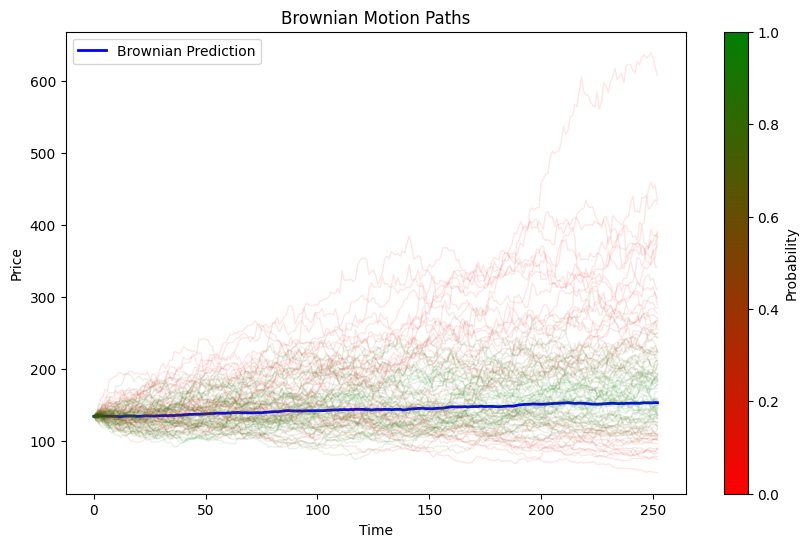

In [152]:
consolidated_path = np.sum(((paths * new_probabilities) / 100), axis=1) + sample.iloc[-1]
consolidated_path -= consolidated_path[0]
consolidated_path += sample.iloc[-1]

lsc = LinearSegmentedColormap.from_list("RedToGreen", ["red", "green"])
fig, axis = plt.subplots(figsize=(10, 6))

axis.plot(consolidated_path, lw=2, color='blue', label='Brownian Prediction')

for i in range(sims):
    axis.plot(paths[:, i], lw=1, color=lsc(new_probabilities[i]), alpha=0.1)

sm = ScalarMappable(cmap=lsc)
prob_bar = plt.colorbar(sm, ax=axis)
prob_bar.set_label('Probability')

axis.set_title('Brownian Motion Paths')
axis.set_xlabel('Time')
axis.set_ylabel('Price')

plt.legend()
plt.show()

## Normalizing Data
Every line in the graph above is a possible movement in price, associated with a probability. To consolidate this data as a single line, sample every time interval, and sum the expected value of each line at that point. The blue line is the Brownian Prediction.

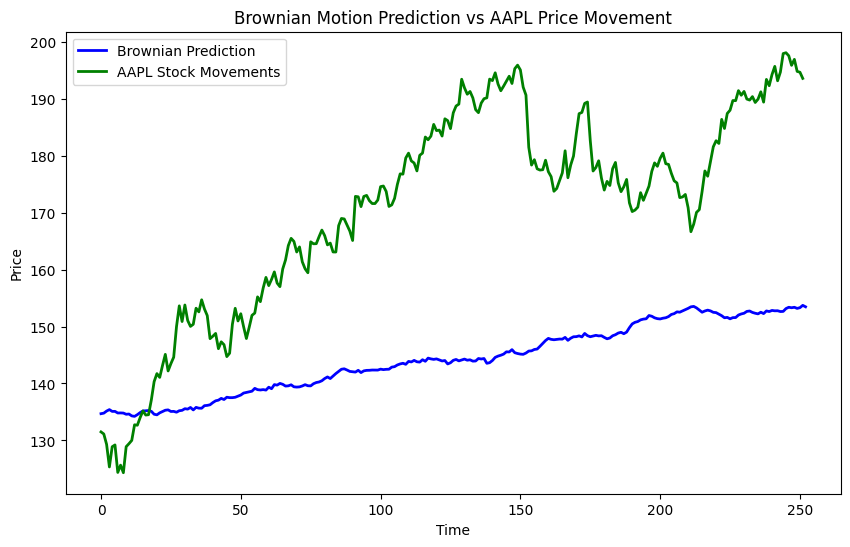

Open            1.957175e+02
High            1.962062e+02
Low             1.947601e+02
Close           1.950892e+02
Volume          3.517510e+07
Dividends       0.000000e+00
Stock Splits    0.000000e+00
Days_Since      2.220000e+02
Name: 150, dtype: float64

In [163]:
fig, axis = plt.subplots(figsize=(10, 6))

axis.plot(consolidated_path, lw=2, color='blue', label='Brownian Prediction')

axis.set_title('Brownian Motion Prediction vs AAPL Price Movement')
axis.set_xlabel('Time')
axis.set_ylabel('Price')

aapl = yf.Ticker("AAPL")
start_date = '2022-12-22'
actual_data = aapl.history(start=start_date)
actual_data.index = actual_data.index.tz_localize(None)
actual_data['Days_Since'] = (actual_data.index - pd.Timestamp('2022-12-22')).days
actual_data.reset_index(drop=True, inplace=True)

axis.plot(actual_data.index, actual_data['Close'], lw=2, color='green', label='AAPL Stock Movements')

plt.legend()
plt.show()
actual_data.iloc[150]

## Drift 
Stocks in the long run have variable drift, which means they don't follow Geometric Brownian Motion. There are ways to account for drift, such as a random walk with a drift coefficient. Implementation coming soon.

## Confidence
As time increases, variance also increases, so we have to take into account our confidence interval at every point. The color gradient of each line at each point should reflect this confidence. Implementation coming soon.
